Adversarial Example Generation
=========================================

In real world applications of machine learning models an important consideration is robustness. If the model performs well only under limited conditions then it may not be suitable for use in a real world, often noisy environment. One way of determining the robustness of a model is to consider which adversarial attacks can defeat it. In this notebook we will follow the [adversarial example generation](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) from the PyTorch website and implement it in torchbearer. 

Before continuing it would be a good idea to look over that example and familarise yourself with the content since we won't be convering the motivation and background in as much detail, prefering to look at the implementational details. 

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Dependencies
========================================
First we install torchbearer if needed. 

In [1]:
#%%
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
    # If problems arise, try
    # pip install git+https://github.com/pytorchbearer/torchbearer
    # import torchbearer
    
print(torchbearer.__version__)

0.3.2


Model and Data
========================================

First we load the same MNIST model that was used in the PyTorch example. Pretrained weights can be found [here](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing). We then load the MNIST dataset test set. We also included some commented out code to train a new model if you prefer. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchbearer import Trial

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


import torchvision.datasets as datasets
import torchvision.transforms as transforms

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
model = Net()
pretrained_model = "data/lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Instead train a model
# trainloader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])),
#         batch_size=128, shuffle=True)
# from torch.optim import Adam
# trial = Trial(model, optimizer=Adam(model.parameters(), 3e-4), criterion=nn.CrossEntropyLoss(), metrics=['acc']).with_train_generator(trainloader)
# _ = trial.to(device).run(5)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The Attack
========================================

The attack used in the PyTorch example is the Fast Gradient Sign Method (FGSM) attack by Goodfellow _et. al._ in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This attack takes advantage of access to the model gradients by simply performing gradient ascent on the input to maximise the classification loss. 

In implementation, the attack is defined by a funciton of the original image, its gradient and an epsilon which is a learning rate for the attack. 

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In torchbearer, we would usually implement something like this in a callback, so that we can create a Trial with an MNIST classifier and take advantage of the training loop and metrics built in. 

So lets think of how we need to perform the attack.
- We need to make sure the input image has gradient which we can set **on_sample**
- Optionally, we can skip images which are already misclassified - which can be done **on_forward**, once we know the predictions
- We need to run the attack after generating the gradients, which can be done **on_backward**
- We would like to do some visualisation, which can be done **on_step_training**, but we will implement this in a separate callback for simplicity. 

No we have a callback structure, we shall implement it, referring to the [testing function](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html#testing-function) in the original PyTorch example. 

In [4]:
from torchbearer import Callback, state_key

VIS_IMAGE = state_key('vis_image')
PERTURBED_IMAGE = state_key('perturbed_image')

class FGSA(Callback):
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.skip = False

    def on_sample(self, state):
        state[torchbearer.X].requires_grad = True

    def on_forward(self, state):
        pred, true = state[torchbearer.Y_PRED], state[torchbearer.Y_TRUE]
        pred = pred.max(1, keepdim=True)[1]
        if pred != true:
          # Skip already misclassified example
          self.skip = True

    def on_backward(self, state):
        if not self.skip:
          image = state[torchbearer.X]
          image_grad = image.grad.data
          perturbed_image = fgsm_attack(image, self.epsilon, image_grad)
          state[PERTURBED_IMAGE] = torch.cat((image, perturbed_image))
          # We replace the prediction so that we can use accuracy metrics easily
          state[torchbearer.Y_PRED] = state[torchbearer.MODEL](perturbed_image)

    def on_step_training(self, state):
        # Make sure to reset the skip flag for each image
        state[torchbearer.MODEL].zero_grad()
        self.skip = False
    

Running and Testing the Attack
==========================================

Before doing any visualisation, lets run the attack and just look at how well the model classifies. We create a trial with a cross entropy loss, our attack as a callback (lets choose a large epsilon so we see a large effect) and accuracy as the only metric. If our attack works we should see a very low accuracy. We'll first run 500 steps without an attack and then 500 steps with an attack and compare this accuracy. 

In [5]:
trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)

trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(0.5)], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)

For our pretrained model we get an accuracy of over 90%. After attacking, we see an accuracy of below 10%. Our attack was successful. So what do our adversarial images look like? Lets add a visualisation callback that retrieves the perturbed image that we saved in state earlier. Recall that we added a pair of images under that state key, the original and the perturbed. The outputs below will show a number of these pairs. 

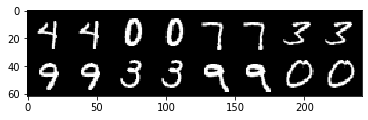

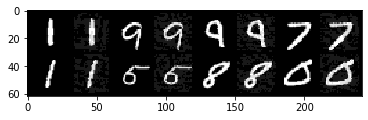

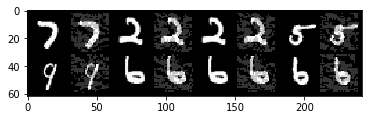

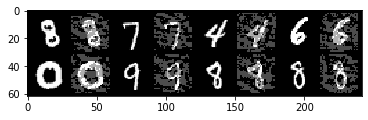

In [6]:
from torchbearer.callbacks import once, on_step_training
from torchbearer.callbacks.imaging import MakeGrid
%matplotlib inline

vis = MakeGrid(PERTURBED_IMAGE).to_pyplot().on_train()
trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(0.0), vis], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)
trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(0.1), vis], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)
trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(0.2), vis], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)
trial = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(0.3), vis], metrics=['acc']).with_train_generator(test_loader, steps=500).to(device).run(1)

The PyTorch example goes on to draw a graph of accuracy for various epsilons. We shall quickly show how we can achieve a similar thing with torchbearer. All we need to do is create a new trial on each loop iteration and grab the accuracies out of the history. We use the same plotting code as the PyTorch example.  

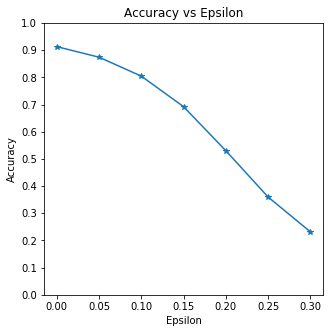

In [7]:
import matplotlib.pyplot as plt
import numpy as np

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []

for eps in epsilons:
    history = Trial(model, criterion=nn.CrossEntropyLoss(), callbacks=[FGSA(eps)], metrics=['acc'], verbose=0).with_train_generator(test_loader).to(device).run(1)
    accuracies.append(history[0][1]['acc'])
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()